# Import Packages

In [1]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time

# Define Parameters

In [2]:
SNR = 10
n_elements = 128
c1 = 0.5
c2 = 1 - c1
T21 = 50
T22 = 90
Nth = 10
n_noise_realizations = 100

tdata = np.linspace(0, 635, n_elements)

#Two parameter definition of s(t) with regularization parameter lambda
def G(t, tau_1, tau_2): 
    function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)
    return function

noiseless_curve = G(tdata, T21, T22)
noise_sd = noiseless_curve[0]/SNR
        
def noise(sd):
    return np.random.normal(0, sd, n_elements)

# Define useful functions

In [3]:
def estimate_parameters(data, lam):
    d_tilde = np.append(data, [0,0])
    def G_tilde(t, tau_1, tau_2): #Augmented for regularization
        return np.append(G(t, tau_1, tau_2), [lam*tau_1, lam*tau_2])
    
    (T21_estimate_reg, T22_estimate_reg), cov_reg = curve_fit(G_tilde, tdata, d_tilde, p0=[40,100])
    if T22_estimate_reg > T21_estimate_reg:
        T21est = T21_estimate_reg
        T22est = T22_estimate_reg
    else:
        T21est = T22_estimate_reg
        T22est = T21_estimate_reg
        
    return T21est, T22est

def find_MSE(time1, time2, reg_param):
    #Apply discrepancy principle to find optimal lambda for specific T21, T22
    
    def G_tilde(t, tau_1, tau_2): #Augmented for regularization
        return np.append(G(t, tau_1, tau_2), [reg_param*tau_1, reg_param*tau_2])
    
    estimated_T21 = []
    estimated_T22 = []
    estimated_T21_reg = []
    estimated_T22_reg = []
    
    #Loop through noise realizations to populate estimated tau arrays
    for j in range(n_noise_realizations):
        np.random.seed(j)
    
        noiseless_curve = G(tdata, time1, time2)
        d = noiseless_curve + noise(noise_sd)
        d_tilde = np.append(d,[0,0])
        
        popt, pcov = curve_fit(G, tdata, d)
        popt_reg, pcov_reg = curve_fit(G_tilde, tdata, d_tilde)

        if popt[1] > popt[0]:
            estimated_T21.append(popt[0])
            estimated_T22.append(popt[1])
        else:
            estimated_T21.append(popt[1])
            estimated_T22.append(popt[0])
            
        if popt_reg[1] > popt_reg[0]:
            estimated_T21_reg.append(popt_reg[0])
            estimated_T22_reg.append(popt_reg[1])
        else:
            estimated_T21_reg.append(popt_reg[1])
            estimated_T22_reg.append(popt_reg[0])
   
    estimated_T21 = np.array(estimated_T21)
    estimated_T22 = np.array(estimated_T22)
    estimated_T21_reg = np.array(estimated_T21_reg)
    estimated_T22_reg = np.array(estimated_T22_reg)
    
    #Calculate MSE for each lambda value
    #T21_error = estimated_T21 - [time1]*n_noise_realizations
    #T22_error = estimated_T22 - [time2]*n_noise_realizations
    #T21_error_reg = estimated_T21_reg - [time1]*n_noise_realizations
    #T22_error_reg = estimated_T22_reg - [time2]*n_noise_realizations
    
    #MSE_T21 = (1/n_noise_realizations)*np.sum(np.square(T21_error))
    #MSE_T22 = (1/n_noise_realizations)*np.sum(np.square(T22_error))
    #MSE_T21_reg = (1/n_noise_realizations)*np.sum(np.square(T21_error_reg))
    #MSE_T22_reg = (1/n_noise_realizations)*np.sum(np.square(T22_error_reg))
    
    MSE_T21 = (1/n_noise_realizations)*(((estimated_T21 - [time1]*n_noise_realizations)**2).sum())
    MSE_T22 = (1/n_noise_realizations)*(((estimated_T22 - [time2]*n_noise_realizations)**2).sum())
    MSE_T21_reg = (1/n_noise_realizations)*(((estimated_T21_reg - [time1]*n_noise_realizations)**2).sum())
    MSE_T22_reg = (1/n_noise_realizations)*(((estimated_T22_reg - [time2]*n_noise_realizations)**2).sum())

    return MSE_T21, MSE_T22, MSE_T21_reg, MSE_T22_reg

def discrepancy_principle(d, sf, error_norm, lambdas):
    discrepancy_lambda = 0
    d_tilde = np.append(d,[0,0])
    
    residual_norm = []

    for lam in lambdas:
        
        def G_tilde(t, tau_1, tau_2): #Augmented for regularization
            return np.append(G(t, tau_1, tau_2), [lam*tau_1, lam*tau_2])
        
        popt, pcov = curve_fit(G_tilde, tdata, d_tilde)

        if popt[1] > popt[0]:
            residual_norm.append(((G(tdata, popt[0], popt[1])-d)**2).sum())
        else:
            residual_norm.append(((G(tdata, popt[1], popt[0])-d)**2).sum())
        
    for i in range(len(residual_norm)):
        if residual_norm[i] < sf*error_norm:
            discrepancy_lambda = lambdas[i]
        else:
            break
    return discrepancy_lambda

def J(t, tau_1, tau_2):
    func1 = ((c1*t/tau_1**2)*np.exp(-t/tau_1)).transpose()
    func2 = ((c2*t/tau_2**2)*np.exp(-t/tau_2)).transpose()
    jacobian = np.stack((func1, func2), axis=-1)
    
    return jacobian
    
def cov(tau_1, tau_2):
    jacobians = J(tdata, tau_1, tau_2).transpose()@J(tdata, tau_1, tau_2)
    covariance = np.linalg.inv(jacobians)
    return noise_sd**2*covariance

#### Discrepancy principle

In [254]:
data = G(tdata, T21, T22) + noise(noise_sd)
d_tilde = np.append(data,[0,0])

safety_factor = 2
error_norm = len(tdata)*(noise_sd)**2
n_lambdas = 50 #Number of lambdas to loop through
lambdas = np.logspace(-4, 0, n_lambdas) #Set range of lambda values
residual_norm = []

discrepancy_lambda = 0

for lam in lambdas:
        
    def G_tilde(t, tau_1, tau_2): #Augmented for regularization
        return np.append(G(t, tau_1, tau_2), [lam*tau_1, lam*tau_2])
    
    popt, pcov = curve_fit(G_tilde, tdata, d_tilde)

    if popt[1] > popt[0]:
        residual_norm.append(((G(tdata, popt[0], popt[1])-data)**2).sum())
    else:
        residual_norm.append(((G(tdata, popt[1], popt[0])-data)**2).sum())
        
for i in range(len(residual_norm)):
    if residual_norm[i] < safety_factor*error_norm:
        discrepancy_lambda = lambdas[i]
    else:
        break

<ipython-input-253-83df7f52c60f>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


Optimal lambda:  0.004291934260128779


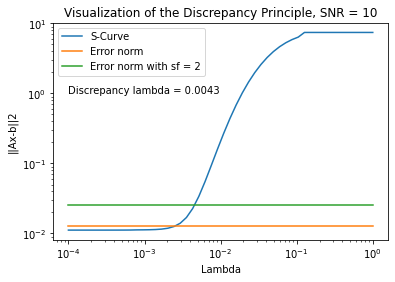

In [258]:
error_line = [error_norm]*n_lambdas
safety_line = [safety_factor*error_norm]*n_lambdas
plt.loglog(lambdas, residual_norm, label='S-Curve')
plt.loglog(lambdas, error_line, label='Error norm')
plt.loglog(lambdas, safety_line, label='Error norm with sf = %s' % safety_factor)
plt.text(0.0001, 1, 'Discrepancy lambda = %s' % round(discrepancy_lambda,4))
plt.legend()
plt.title('Visualization of the Discrepancy Principle, SNR = %s' % SNR)
plt.xlabel('Lambda')
plt.ylabel('||Ax-b||2')
print('Optimal lambda: ', discrepancy_lambda)

#### Using the discrepancy principle as an estimate, find optimal lambda values for T21 and T22

In [6]:
def find_optimal_lambdas(time1, time2):
    disclam = 0.01
    candidate_lambdas = np.logspace(np.log10(disclam)-2, np.log10(disclam)+2, 100)
    
    T21_MSE_values = []
    T22_MSE_values = []
    
    for lam in candidate_lambdas:
        MSE_T21, MSE_T22, MSE_T21_reg, MSE_T22_reg = find_MSE(time1, time2, lam)
        #T21_ratio = MSE_T21_reg/MSE_T21
        #T22_ratio = MSE_T22_reg/MSE_T22
        
        #T21_MSE_ratios.append(T21_ratio)
        #T22_MSE_ratios.append(T22_ratio)
        T21_MSE_values.append(MSE_T21_reg/MSE_T21)
        T22_MSE_values.append(MSE_T22_reg/MSE_T22)
    
    T21_MSE_values = np.array(T21_MSE_values)
    T22_MSE_values = np.array(T22_MSE_values)
        
    T21_min_index = np.argmin(T21_MSE_values)
    T22_min_index = np.argmin(T22_MSE_values)
    
    T21_lambda = candidate_lambdas[T21_min_index]
    T22_lambda = candidate_lambdas[T22_min_index]
    
    return T21_lambda, T22_lambda

# Test Regularized against Non-regularized

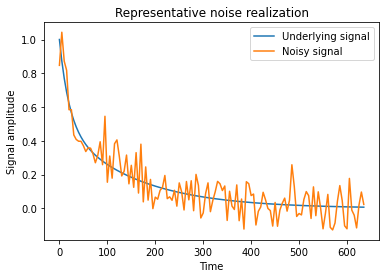

In [7]:
d = noiseless_curve + noise(noise_sd)
d_tilde = np.append(d, [0,0])

plt.plot(tdata, noiseless_curve, label='Underlying signal')
plt.plot(tdata, d, label='Noisy signal')
plt.title('Representative noise realization')
plt.xlabel('Time')
plt.ylabel('Signal amplitude')
plt.legend()
plt.show()

#### Test both against many noise realizations

In [29]:
reg_param = 100

T21_list=[]
T22_list=[]
T21_reg_list=[]
T22_reg_list=[]
 
def G_tilde(t, tau_1, tau_2): #Augmented for regularization
    return np.append(G(t, tau_1, tau_2), [reg_param*tau_1, 0*tau_2])

for i in np.arange(n_noise_realizations):
    np.random.seed(i)
    d = noiseless_curve + noise(noise_sd)
    d_tilde = np.append(d, [0,0])
    
    (T21_estimate, T22_estimate), cov = curve_fit(G, tdata, d, p0=[40,100])
    (T21_estimate_reg, T22_estimate_reg), cov_reg = curve_fit(G_tilde, tdata, d_tilde, p0=[40,100])
    
    if T22_estimate > T21_estimate:
        T21_list.append(T21_estimate)
        T22_list.append(T22_estimate)
    else:
        T21_list.append(T22_estimate)
        T22_list.append(T21_estimate)
        
    if T22_estimate_reg > T21_estimate_reg:
        T21_reg_list.append(T21_estimate_reg)
        T22_reg_list.append(T22_estimate_reg)
    else:
        T21_reg_list.append(T22_estimate_reg)
        T22_reg_list.append(T21_estimate_reg)

T21_list = np.array(T21_list)
T22_list = np.array(T22_list)
T21_reg_list = np.array(T21_reg_list)
T22_reg_list = np.array(T22_reg_list)

<ipython-input-2-0d97d8dded4a>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


#### Calculate Bias, variance, and MSE for both regularized and unregularized

In [30]:
T21_bias = np.mean(T21_list - [T21 for tau in T21_list])
T22_bias = np.mean(T22_list - [T22 for tau in T22_list])
T21_reg_bias = np.mean(T21_reg_list - [T21 for tau in T21_reg_list])
T22_reg_bias = np.mean(T22_reg_list - [T22 for tau in T22_reg_list])

T21_variance = statistics.pvariance(T21_list)
T22_variance = statistics.pvariance(T22_list)
T21_reg_variance = statistics.pvariance(T21_reg_list)
T22_reg_variance = statistics.pvariance(T22_reg_list)

T21_MSE = (1/n_noise_realizations)*(((T21_list - [T21 for tau in T21_list])**2).sum())
T22_MSE = (1/n_noise_realizations)*(((T22_list - [T22 for tau in T22_list])**2).sum())
T21_reg_MSE = (1/n_noise_realizations)*(((T21_reg_list - [T21 for tau in T21_reg_list])**2).sum())
T22_reg_MSE = (1/n_noise_realizations)*(((T22_reg_list - [T22 for tau in T22_reg_list])**2).sum())

print('Unregularized T21 bias, variance, and MSE:', T21_bias, T21_variance, T21_MSE)
print('Unregularized T22 bias, variance, and MSE:', T22_bias, T22_variance, T22_MSE)
print('Regularized T21 bias, variance, and MSE:', T21_reg_bias, T21_reg_variance, T21_reg_MSE)
print('Regularized T22 bias, variance, and MSE:', T22_reg_bias, T22_reg_variance, T22_reg_MSE)

Unregularized T21 bias, variance, and MSE: -0.6441030724374021 16.66809510281806 17.082963870741363
Unregularized T22 bias, variance, and MSE: 0.4206919529319372 115.60965049282674 115.7866322120884
Regularized T21 bias, variance, and MSE: -19.999999999998597 1.4027875918189542e-22 399.99999999994384
Regularized T22 bias, variance, and MSE: 8.197121533648811 109.33468191510163 176.52748335251064


#### Graph the range of results

<Figure size 864x288 with 0 Axes>

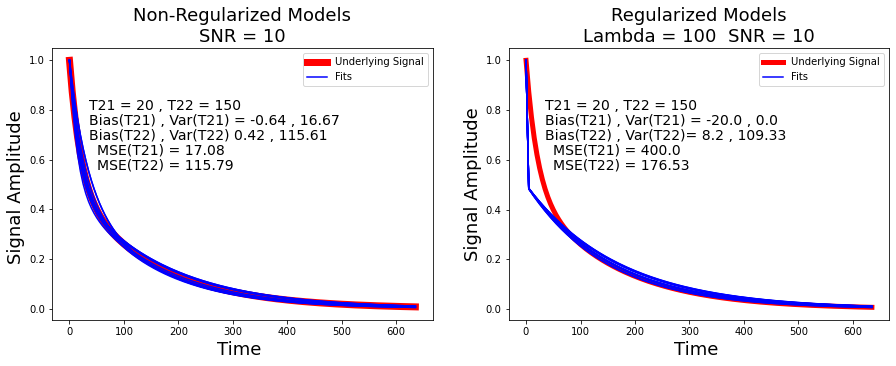

In [31]:
fig=plt.figure(figsize=(12,4))
f, axs = plt.subplots(2,2,figsize=(15,5))

#Non-regularized plot
plt.subplot(1, 2, 1) 
plt.title("Non-Regularized Models\nSNR = %s" % SNR, fontsize=18)
plt.text(35, 0.80, "T21 = %s , T22 = %s" % (T21,T22), fontsize=14)
plt.text(35, 0.74, "Bias(T21) , Var(T21) = %s , %s" % (round(T21_bias, 2), (round (T21_variance,2) ) ), fontsize=14)
plt.text(35, 0.68, "Bias(T22) , Var(T22) %s , %s" % (round(T22_bias, 2), (round (T22_variance,2) ) ), fontsize=14)
plt.text(50, 0.62, "MSE(T21) = %s" % round(T21_MSE, 2), fontsize=14)
plt.text(50, 0.56, "MSE(T22) = %s" % round(T22_MSE, 2), fontsize=14)
plt.xlabel('Time ', fontsize=18)
plt.ylabel('Signal Amplitude ', fontsize=18)
plt.plot(tdata, noiseless_curve, 'r', label = 'Underlying Signal', linewidth=7.0)

#Create legend using only first curve; the rest use this same legend
model_results = G(tdata, T21_list[0],T22_list[0])
plt.plot(tdata, model_results, 'b', label='Fits')
plt.legend()

#Now plot all the rest of the curves, each corresponding to a solution from a particular noise realization
for i in np.arange(n_noise_realizations):
    if i%Nth==0:
        model_results = G(tdata, T21_list[i],T22_list[i])
        plt.plot(tdata, model_results, 'b', label='Fitting Function')

#Regularized plot
plt.subplot(1, 2, 2) 
plt.title("Regularized Models\nLambda = %s  SNR = %s" % (reg_param, SNR), fontsize=18)
plt.text(35, 0.80, "T21 = %s , T22 = %s" % (T21,T22), fontsize=14)
plt.text(35, 0.74, "Bias(T21) , Var(T21) = %s , %s" % (round(T21_reg_bias, 2), round(T21_reg_variance,2) ), fontsize=14)
plt.text(35, 0.68, "Bias(T22) , Var(T22)= %s , %s" % (round(T22_reg_bias, 2),(round (T22_reg_variance,2) ) ), fontsize=14)
plt.text(50, 0.62, "MSE(T21) = %s" % round(T21_reg_MSE, 2), fontsize=14)
plt.text(50, 0.56, "MSE(T22) = %s" % round(T22_reg_MSE, 2), fontsize=14)
plt.xlabel('Time ', fontsize=18)
plt.ylabel('Signal Amplitude', fontsize=18)
plt.plot(tdata, noiseless_curve, 'r', label='Underlying Signal', linewidth=5.0) 

#Create legend using only first curve; the rest use this same legend
model_results_reg=G(tdata, T21_reg_list[0], T22_reg_list[0])
plt.plot(tdata, model_results_reg, 'b', label='Fits')
plt.legend()

#Now plot all the rest of the curves, each corresponding to a solution from a particular noise realization
for i in np.arange(n_noise_realizations):
    if i%Nth==0:
        model_results_reg = G(tdata, T21_reg_list[i],T22_reg_list[i])
        plt.plot(tdata, model_results_reg, 'b', label='Fitting Function')
        
plt.show()

#### Determine success by comparing MSE

In [11]:
T21_results_nonreg=f"Non-regularized:  T21 bias = {round(T21_bias,2)}, variance={round(T21_variance,2)}, MSE={round(T21_MSE,2)}"
print(T21_results_nonreg)
T21_results_reg=f"Regularized:  T21 bias = {round(T21_reg_bias,2)}, variance={round(T21_reg_variance,2)}, MSE={round(T21_reg_MSE,2)}"
print(T21_results_reg)

T21_factor_better_with_reg=T21_MSE/T21_reg_MSE
T21_factor_worse_with_reg=T21_reg_MSE/T21_MSE
if (T21_MSE > T21_reg_MSE):
    print(f"Regularization succeeded for T21; T21 MSE better by a factor of {round(T21_factor_better_with_reg,2)}")
else:
    print(f"Regularization failed for T21; T21 MSE worse by a factor {round(T21_factor_worse_with_reg,2)}")
print("\n")

T22_results_nonreg=f"Non-regularized:  T22 bias = {round(T22_bias,2)}, variance={round(T22_variance,2)}, MSE={round(T22_MSE,2)}"
print(T22_results_nonreg)
T22_results_reg=f"Regularized:  T22 bias = {round(T22_reg_bias,2)}, variance={round(T22_reg_variance,2)}, MSE={round(T22_reg_MSE,2)}"
print(T22_results_reg)

T22_factor_better_with_reg=T22_MSE/T22_reg_MSE
T22_factor_worse_with_reg=T22_reg_MSE/T22_MSE
if (T22_MSE > T22_reg_MSE):
    print(f"Regularization succeeded for T22; T22 MSE better by a factor of {round(T22_factor_better_with_reg,2)}")
else:
    print(f"Regularization failed for T22; T22 MSE worse by a factor {round(T22_factor_worse_with_reg,2)}")

Non-regularized:  T21 bias = -0.64, variance=16.67, MSE=17.08
Regularized:  T21 bias = -0.64, variance=16.67, MSE=17.08
Regularization failed for T21; T21 MSE worse by a factor 1.0


Non-regularized:  T22 bias = 0.42, variance=115.61, MSE=115.79
Regularized:  T22 bias = 0.42, variance=115.61, MSE=115.79
Regularization failed for T22; T22 MSE worse by a factor 1.0


# Use the Discrepancy Prinicple to find good lambdas, loop through several safety factors

In [204]:
error_norm = len(tdata)*(noise_sd)**2
n_lambdas = 50 #Number of lambdas to loop through
lambdas = np.logspace(-4, 0, n_lambdas) #Set range of lambda values
safety_factor = 1

disc_underlying = G(tdata, T21, T22)
n_sf = 31
sf_list = np.linspace(1, 7, n_sf)

In [205]:
def average_discrepancy_lambda(disc_underlying, safety_factor, lambdas, noise_sd, verbose = False):
#Gives average value of the lambda given by the discrepancy principle over n noise realizations
#disc_underlying is the underlying function used to generate noise realizations
#lambdas is the list of lambdas to be used to generate the S-curves
#Returns the average lambda and the variance of the lambdas

    lambda_list = []
    tau1_list = []
    tau2_list = []
    
    for n in range(n_noise_realizations):
        np.random.seed(n)
        data = disc_underlying + noise(noise_sd)
        data_tilde = np.append(data, [0,0])
    
        disclam = discrepancy_principle(data, safety_factor, error_norm, lambdas)
        lambda_list.append(disclam)
    
        def G_tilde(t, tau_1, tau_2): #Augmented for regularization
            return np.append(G(t, tau_1, tau_2), [disclam*tau_1, disclam*tau_2])
    
        popt, pcov = curve_fit(G_tilde, tdata, data_tilde, p0 = [40, 100], maxfev = 1000)
        if popt[1] > popt[0]:
            tau1_list.append(popt[0])
            tau2_list.append(popt[1])
        else:
            tau1_list.append(popt[1])
            tau2_list.append(popt[0])
    
    tau1_list = np.array(tau1_list)
    tau2_list = np.array(tau2_list)
    lambda_list = np.array(lambda_list)

    if verbose == True:
        print('T21 Bias =', np.mean(tau1_list - [T21]*n_noise_realizations))
        print('T22 Bias =', np.mean(tau2_list - [T22]*n_noise_realizations))
        print('T21 Variance =', statistics.pvariance(tau1_list))
        print('T22 Variance =', statistics.pvariance(tau2_list))
        print('T21 MSE =', (1/n_noise_realizations)*(((tau1_list - [T21]*n_noise_realizations)**2).sum()))
        print('T22 MSE =', (1/n_noise_realizations)*(((tau2_list - [T22]*n_noise_realizations)**2).sum()))
        print('Average Lambda:', lambda_list.sum()/n_noise_realizations, 'Variance =', statistics.pvariance(lambda_list))
    
    return lambda_list.sum()/n_noise_realizations, statistics.pvariance(lambda_list)

average_discrepancy_lambda(disc_underlying, safety_factor, lambdas, noise_sd, verbose = True)

<ipython-input-158-83df7f52c60f>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


T21 Bias = 3.6702403831580903
T22 Bias = -4.957202805460943
T21 Variance = 21.828692570154338
T22 Variance = 36.461154840572156
T21 MSE = 35.29935704031878
T22 MSE = 61.035014495042006
Average Lambda: 0.0009323280858715993 Variance = 1.0704981840845694e-06


(0.0009323280858715993, 1.0704981840845694e-06)

In [250]:
start_time = time.time()
#Find MSE, variance, and bias as a function of lambda
tau_1_MSE = []
tau_1_variance = []
tau_1_bias = []

tau_2_MSE = []
tau_2_variance = []
tau_2_bias = []

lambda_mean = []
lambda_variance = []
    
for sf in sf_list:
    lambda_list = []
    tau1_list = []
    tau2_list = []
    
    for n in range(n_noise_realizations):
        np.random.seed(n)
        data = disc_underlying + noise(noise_sd)
        data_tilde = np.append(data, [0,0])
        
        disclam = discrepancy_principle(data, sf, error_norm, lambdas)
        lambda_list.append(disclam)
        
        def G_tilde(t, tau_1, tau_2): #Augmented for regularization
            return np.append(G(t, tau_1, tau_2), [disclam*tau_1, disclam*tau_2])
        
        popt, pcov = curve_fit(G_tilde, tdata, data_tilde, p0 = [40, 100], maxfev = 1000)

        if popt[1] > popt[0]:
            tau1_list.append(popt[0])
            tau2_list.append(popt[1])
        else:
            tau1_list.append(popt[1])
            tau2_list.append(popt[0])
    
    tau1_list = np.array(tau1_list)
    tau2_list = np.array(tau2_list)
    lambda_list = np.array(lambda_list)
    
    tau_1_bias.append(np.mean(tau1_list - [T21]*n_noise_realizations))
    tau_2_bias.append(np.mean(tau2_list - [T22]*n_noise_realizations))
    
    tau_1_variance.append(statistics.pvariance(tau1_list))
    tau_2_variance.append(statistics.pvariance(tau2_list))
    
    MSE_lambda_tau_1 = (1/n_noise_realizations)*(((tau1_list - [T21]*n_noise_realizations)**2).sum())
    MSE_lambda_tau_2 = (1/n_noise_realizations)*(((tau2_list - [T22]*n_noise_realizations)**2).sum())
    
    tau_1_MSE.append(MSE_lambda_tau_1)
    tau_2_MSE.append(MSE_lambda_tau_2)
    
    lambda_mean.append(lambda_list.sum()/n_noise_realizations)
    lambda_variance.append(statistics.pvariance(lambda_list))
print('Runtime:', time.time()-start_time, 'seconds')

<ipython-input-247-1ebc1b44a680>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


Runtime: 131.2293496131897 seconds


In [251]:
#Calculate unregularized MSE and CRLB
T21_CRLB = cov(T21, T22)[0,0]
T22_CRLB = cov(T21, T22)[1,1]
print('CRLB:',T21_CRLB, T22_CRLB)

T21_MSE, T22_MSE, MSE_T21_reg, MSE_T22_reg = find_MSE(T21, T22, 0)
print('Unreg MSE:', T21_MSE, T22_MSE)

CRLB: 1.7747427716331277 3.1947774357201384
Unreg MSE: 1.3204060503036525 2.2890448198034


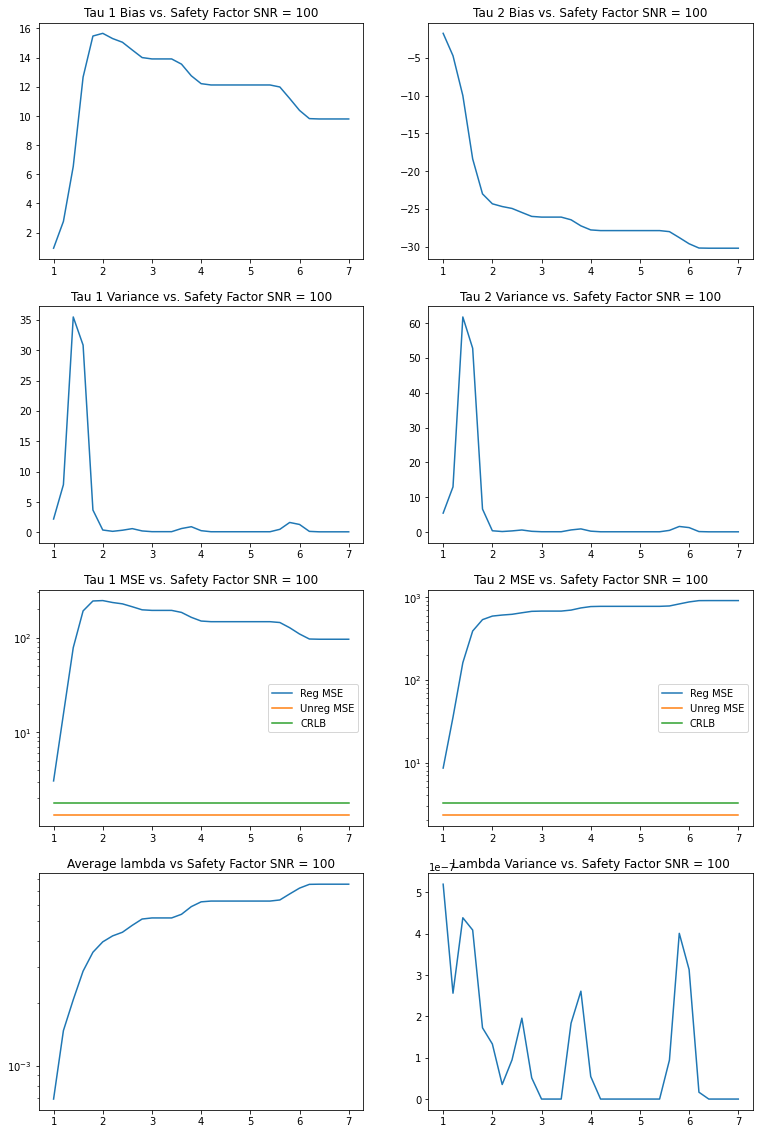

In [252]:
figure, axis = plt.subplots(4,2, figsize = (12.8, 20))

axis[0,0].plot(sf_list, tau_1_bias)
axis[0,0].set_title('Tau 1 Bias vs. Safety Factor SNR = %s' % SNR)

axis[1,0].plot(sf_list, tau_1_variance)
axis[1,0].set_title('Tau 1 Variance vs. Safety Factor SNR = %s' % SNR)

axis[2,0].semilogy(sf_list, tau_1_MSE, label='Reg MSE')
axis[2,0].semilogy(sf_list, [T21_MSE]*n_sf, label='Unreg MSE')
axis[2,0].semilogy(sf_list, [T21_CRLB]*n_sf, label='CRLB')
axis[2,0].set_title('Tau 1 MSE vs. Safety Factor SNR = %s' % SNR)
axis[2,0].legend()

axis[0,1].plot(sf_list, tau_2_bias)
axis[0,1].set_title('Tau 2 Bias vs. Safety Factor SNR = %s' % SNR)

axis[1,1].plot(sf_list, tau_2_variance)
axis[1,1].set_title('Tau 2 Variance vs. Safety Factor SNR = %s' % SNR)

axis[2,1].semilogy(sf_list, tau_2_MSE, label='Reg MSE')
axis[2,1].semilogy(sf_list, [T22_MSE]*n_sf, label='Unreg MSE')
axis[2,1].semilogy(sf_list, [T22_CRLB]*n_sf, label='CRLB')
axis[2,1].set_title('Tau 2 MSE vs. Safety Factor SNR = %s' % SNR)
axis[2,1].legend()

axis[3,0].semilogy(sf_list, lambda_mean)
axis[3,0].set_title('Average lambda vs Safety Factor SNR = %s' % SNR)

axis[3,1].plot(sf_list,lambda_variance)
axis[3,1].set_title('Lambda Variance vs. Safety Factor SNR = %s' % SNR)

plt.show()

## Generate an L-Curve

In [52]:
n_lambdas = 11 #Number of lambdas to loop through
lambdas = np.logspace(-4, 0, n_lambdas) #Set range of lambda values

#Calculate residual norm and solution norm for each value of lambda
residual_norm = []
solution_norm = []

#def G_tilde_mod(t, tau_1, tau_2):
    #return np.append(G(t, tau_1, tau_2), [reg_param*(tau_1 - T21), reg_param*(tau_2 - T22)])

for lam in lambdas:
        
    def G_tilde(t, tau_1, tau_2): #Augmented for regularization
        return np.append(G(t, tau_1, tau_2), [lam*tau_1, lam*tau_2])

    estimated_tau_1 = []
    estimated_tau_2 = []
    
    def noise(sd):
        return np.random.normal(0, sd, n_elements)
        
    d = noiseless_curve + noise(noise_sd)
    d_tilde = np.append(d,[0,0])
    
    popt, pcov = curve_fit(G_tilde, tdata, d_tilde)

    if popt[1] > popt[0]:
        estimated_tau_1.append(popt[0])
        estimated_tau_2.append(popt[1])
        residual_norm.append(((G(tdata, popt[0], popt[1])-d)**2).sum())
    else:
        estimated_tau_1.append(popt[1])
        estimated_tau_2.append(popt[0])
        residual_norm.append(((G(tdata, popt[1], popt[0])-d)**2).sum())
            
    solution_norm.append((popt**2).sum())

<ipython-input-2-33188db432e5>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


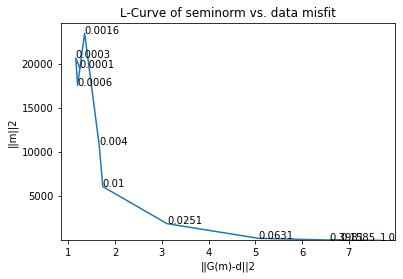

In [53]:
plt.plot(residual_norm, solution_norm)
plt.title('L-Curve of seminorm vs. data misfit')
plt.ylabel('||m||2')
plt.xlabel('||G(m)-d||2')
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(10**(-1))

for k, label in enumerate(lambdas):
    plt.text(residual_norm[k], solution_norm[k], round(label,4))

plt.show()

# Apply Generalized Cross Validation to find a good lambda

In [6]:
def get_GCV(GCV_data, GCV_lam):
    GCVd_tilde = np.append(GCV_data, [0,0])

    def G_tilde(lam):
        def Gt_lam(t, tau1, tau2):
            return np.append(G(t, tau1, tau2), [lam*tau1, lam*tau2])
        return Gt_lam

    popt, pcov = curve_fit(G_tilde(GCV_lam), tdata, GCVd_tilde)

    if popt[1]>popt[0]:
        tau1_GCV = popt[0]
        tau2_GCV = popt[1]
    else:
        tau1_GCV = popt[1]
        tau2_GCV = popt[0]
    
    GCVjacobian = J(tdata, tau1_GCV, tau2_GCV)
    GCV_residual = ((G(tdata, tau1_GCV, tau2_GCV)-GCV_data)**2).sum()
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*np.identity(2))@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

In [5]:
def get_avg_GCV(GCVlambdas, tau1, tau2, n, verbose=False):
    minGCV_list = []
    T21est = []
    T22est = []
    for i in range(n):
        np.random.seed(i)
        #Gets a list of the lambdas given by GCV for each noise realization
        noiseless_curve = G(tdata, tau1, tau2)
        GCV_data = noiseless_curve + noise(noise_sd)
        GCVd_tilde = np.append(GCV_data, [0,0])
        
        GCV_values = []
        for GCVlam in GCVlambdas:
            GCV_values.append(get_GCV(GCV_data, GCVlam))
    
        min_GCV = GCVlambdas[np.argmin(GCV_values)]
        minGCV_list.append(min_GCV)
        #Estimate parameters using the GCV lambdas, then calculate the MSE of these estimates
        def G_tilde(lam):
            def Gt_lam(t, tau_1, tau_2):
                return np.append(G(t, tau_1, tau_2), [lam*tau_1, lam*tau_2])
            return Gt_lam

        popt, pcov = curve_fit(G_tilde(min_GCV), tdata, GCVd_tilde, p0=[40,100])

        if popt[1]>popt[0]:
            T21est.append(popt[0])
            T22est.append(popt[1])
        else:
            T21est.append(popt[1])
            T22est.append(popt[0])
   
    T21est = np.array(T21est)
    T22est = np.array(T22est)
    #Calculate bias, variance, and MSE of the estimates
    T21_bias = (T21est-[tau1]*n).sum()/n
    T22_bias = (T22est-[tau2]*n).sum()/n
    
    T21_variance = statistics.pvariance(T21est)
    T22_variance = statistics.pvariance(T22est)
    
    T21_MSE = T21_variance + T21_bias**2
    T22_MSE = T22_variance + T22_bias**2
    
    #Get the average lambda given by GCV over n noise realizations
    minGCV_list = np.array(minGCV_list)
    avgGCV = minGCV_list.sum()/n
    varGCV = statistics.pvariance(minGCV_list)
    if verbose==True:
        return avgGCV, varGCV, T21_bias, T21_variance, T21_MSE, T22_bias, T22_variance, T22_MSE
    else:
        return avgGCV

In [138]:
GCV_data = noiseless_curve + noise(noise_sd)
n_GCVlambdas = 51
GCVlambdas = np.logspace(-5,0, n_GCVlambdas)

GCV_values = []
for GCVlam in GCVlambdas:
    GCV_values.append(get_GCV(GCV_data, GCVlam))
    
min_GCV = GCVlambdas[np.argmin(GCV_values)]

<ipython-input-131-33188db432e5>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


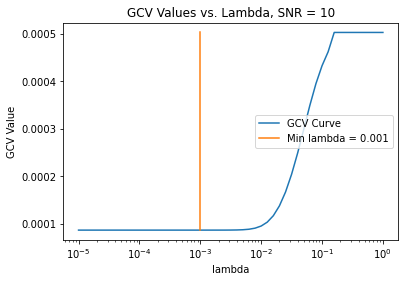

In [139]:
plt.semilogx(GCVlambdas, GCV_values, label = 'GCV Curve')
plt.semilogx([min_GCV]*n_GCVlambdas, GCV_values, label = 'Min lambda = %s'%round(min_GCV, 5))
plt.title('GCV Values vs. Lambda, SNR = %s' % SNR)
plt.xlabel('lambda')
plt.ylabel('GCV Value')
plt.legend()

# Loop through values of lambda

In [291]:
n_lambdas = 100 #Number of lambdas to loop through
lambdas = np.logspace(-7, 3, num = n_lambdas) #Set range of lambda values
#safety_factor = 2
#disc_underlying = G(tdata, T21, T22)
#avg_lambda, lambda_var = average_discrepancy_lambda(disc_underlying, safety_factor, lambdas, noise_sd, verbose = False)
avgGCV = get_avg_GCV(lambdas, T21, T22, n_noise_realizations)
#Calculate unregularized MSE and CRLB
T21_CRLB = cov(T21, T22)[0,0]
T22_CRLB = cov(T21, T22)[1,1]
print('CRLB:',T21_CRLB, T22_CRLB)

T21_MSE, T22_MSE, MSE_T21_reg, MSE_T22_reg = find_MSE(T21, T22, 0)
print('Unreg MSE:', T21_MSE, T22_MSE)

<ipython-input-274-33188db432e5>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


CRLB: 177.4742771633128 319.4777435720139
Unreg MSE: 120.33471709796562 207.70421432823443


In [275]:
#Find MSE, variance, and bias as a function of lambda
tau_1_MSE = []
tau_1_variance = []
tau_1_bias = []

tau_2_MSE = []
tau_2_variance = []
tau_2_bias = []

for reg_param in lambdas:
        
    estimated_tau_1 = []
    estimated_tau_2 = []

    def G_tilde(t, tau_1, tau_2): #Augmented for regularization
        return np.append(G(t, tau_1, tau_2), [reg_param*tau_1, reg_param*tau_2])
    
    #Loop through noise realizations to populate estimated tau arrays
    for j in range(n_noise_realizations):
        np.random.seed(j)

        d = noiseless_curve + noise(noise_sd)
        d_tilde = np.append(d, [0,0])
    
        popt, pcov = curve_fit(G_tilde, tdata, d_tilde, p0 = [40, 100])

        if popt[1] > popt[0]:
            estimated_tau_1.append(popt[0])
            estimated_tau_2.append(popt[1])
        else:
            estimated_tau_1.append(popt[1])
            estimated_tau_2.append(popt[0])
    
    estimated_tau_1 = np.array(estimated_tau_1)
    estimated_tau_2 = np.array(estimated_tau_2)
    
    #Calculate bias, variance, and MSE for each lambda value    
    tau_1_bias.append(np.mean(estimated_tau_1 - [T21 for tau in estimated_tau_1]))
    tau_2_bias.append(np.mean(estimated_tau_2 - [T22 for tau in estimated_tau_2]))
    
    tau_1_variance.append(statistics.pvariance(estimated_tau_1))
    tau_2_variance.append(statistics.pvariance(estimated_tau_2))
    
    MSE_lambda_tau_1 = (1/n_noise_realizations)*(((estimated_tau_1 - [T21 for tau in estimated_tau_1])**2).sum())
    MSE_lambda_tau_2 = (1/n_noise_realizations)*(((estimated_tau_2 - [T22 for tau in estimated_tau_2])**2).sum())
    
    tau_1_MSE.append(MSE_lambda_tau_1)
    tau_2_MSE.append(MSE_lambda_tau_2)

<ipython-input-274-33188db432e5>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


## Plot graphs vs Lambda

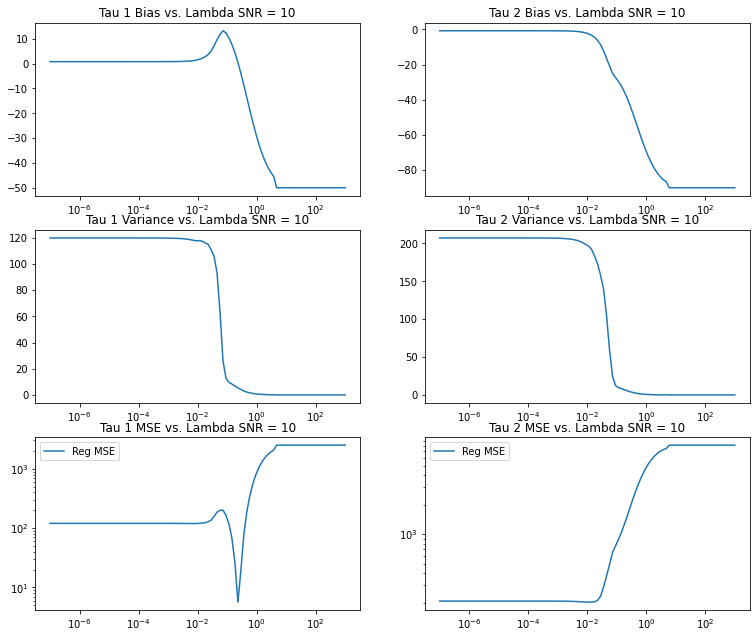

In [283]:
figure, axis = plt.subplots(3,2, figsize = (12.8, 10.8))

axis[0,0].semilogx(lambdas, tau_1_bias)
axis[0,0].set_title('Tau 1 Bias vs. Lambda SNR = %s' % SNR)

axis[1,0].semilogx(lambdas, tau_1_variance)
axis[1,0].set_title('Tau 1 Variance vs. Lambda SNR = %s' % SNR)

axis[2,0].loglog(lambdas, tau_1_MSE, label='Reg MSE')
#axis[2,0].loglog(lambdas, [T21_MSE]*n_lambdas, label='Unreg MSE')
#axis[2,0].loglog(lambdas, [T21_CRLB]*n_lambdas, label='CRLB')
#axis[2,0].loglog([avgGCV]*n_lambdas, tau_1_MSE, label='Avg Lambda = %s' % round(avgGCV,5))
axis[2,0].set_title('Tau 1 MSE vs. Lambda SNR = %s' % SNR)
axis[2,0].legend()

axis[0,1].semilogx(lambdas, tau_2_bias)
axis[0,1].set_title('Tau 2 Bias vs. Lambda SNR = %s' % SNR)

axis[1,1].semilogx(lambdas, tau_2_variance)
axis[1,1].set_title('Tau 2 Variance vs. Lambda SNR = %s' % SNR)

axis[2,1].loglog(lambdas, tau_2_MSE, label='Reg MSE')
#axis[2,1].loglog(lambdas, [T22_MSE]*n_lambdas, label='Unreg MSE')
#axis[2,1].loglog(lambdas, [T22_CRLB]*n_lambdas, label='CRLB')
#axis[2,1].loglog([avgGCV]*n_lambdas, tau_2_MSE, label='Avg Lambda = %s' % round(avgGCV,5))
axis[2,1].set_title('Tau 2 MSE vs. Lambda SNR = %s' % SNR)
axis[2,1].legend()

plt.show()

# Make a heat map for T21, T22 values

In [109]:
n_T21 = 7
n_T22 = 9
T21_values = np.linspace(10, 70, n_T21)
T22_values = np.linspace(80, 160, n_T22)

T21_heatmap = np.zeros((n_T21, n_T22))
T22_heatmap = np.zeros((n_T21, n_T22))

T21_lambdas_heatmap = np.zeros((n_T21, n_T22))
T22_lambdas_heatmap = np.zeros((n_T21, n_T22))

for i in range(n_T21):
    for j in range(n_T22):
        T21_lambda, T22_lambda = find_optimal_lambdas(T21_values[i], T22_values[j])
        
        T21_lambdas_heatmap[i][j] = T21_lambda
        T22_lambdas_heatmap[i][j] = T22_lambda
        
        T21_lambda_MSE = find_MSE(T21_values[i], T22_values[j], T21_lambda)
        T22_lambda_MSE = find_MSE(T21_values[i], T22_values[j], T22_lambda)
        
        T21_ratio = T21_lambda_MSE[2]/T21_lambda_MSE[0]
        T22_ratio = T22_lambda_MSE[3]/T22_lambda_MSE[1]
        
        T21_heatmap[i][j] = T21_ratio
        T22_heatmap[i][j] = T22_ratio

<ipython-input-93-2ceda55a0bd1>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


#### Plot the heatmaps

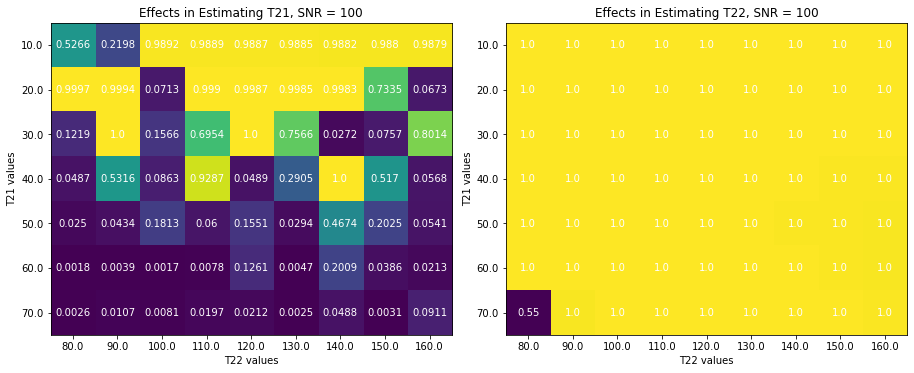

In [110]:
fig, ax = plt.subplots(1, 2, figsize = (12.8, 10.8))
imT21 = ax[0].imshow(T21_heatmap)
imT22 = ax[1].imshow(T22_heatmap)

ax[0].set_xticks(np.arange(n_T22))
ax[0].set_yticks(np.arange(n_T21))
ax[0].set_xticklabels(T22_values)
ax[0].set_yticklabels(T21_values)
ax[0].set_ylabel('T21 values')
ax[0].set_xlabel('T22 values')

ax[1].set_xticks(np.arange(n_T22))
ax[1].set_yticks(np.arange(n_T21))
ax[1].set_xticklabels(T22_values)
ax[1].set_yticklabels(T21_values)
ax[1].set_ylabel('T21 values')
ax[1].set_xlabel('T22 values')

for i in range(n_T21):
    for j in range(n_T22):
        text = ax[0].text(j, i, round(T21_heatmap[i, j], 4), ha="center", va="center", color="w")
for i in range(n_T21):
    for j in range(n_T22):
        text = ax[1].text(j, i, round(T22_heatmap[i, j], 2), ha="center", va="center", color="w")
        

ax[0].set_title("Effects in Estimating T21, SNR = %s" % SNR)
ax[1].set_title("Effects in Estimating T22, SNR = %s" % SNR)
fig.tight_layout()
plt.show()

#### Plot the optimal lambdas

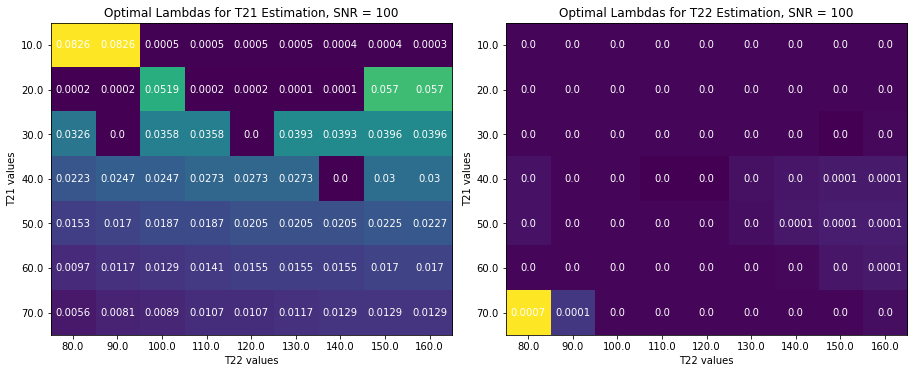

In [111]:
fig, ax = plt.subplots(1, 2, figsize = (12.8, 10.8))
imT21 = ax[0].imshow(T21_lambdas_heatmap)
imT22 = ax[1].imshow(T22_lambdas_heatmap)

ax[0].set_xticks(np.arange(n_T22))
ax[0].set_yticks(np.arange(n_T21))
ax[0].set_xticklabels(T22_values)
ax[0].set_yticklabels(T21_values)
ax[0].set_ylabel('T21 values')
ax[0].set_xlabel('T22 values')

ax[1].set_xticks(np.arange(n_T22))
ax[1].set_yticks(np.arange(n_T21))
ax[1].set_xticklabels(T22_values)
ax[1].set_yticklabels(T21_values)
ax[1].set_ylabel('T21 values')
ax[1].set_xlabel('T22 values')

for i in range(n_T21):
    for j in range(n_T22):
        text = ax[0].text(j, i, round(T21_lambdas_heatmap[i, j], 4), ha="center", va="center", color="w")
for i in range(n_T21):
    for j in range(n_T22):
        text = ax[1].text(j, i, round(T22_lambdas_heatmap[i, j], 4), ha="center", va="center", color="w")
        

ax[0].set_title("Optimal Lambdas for T21 Estimation, SNR = %s" % SNR)
ax[1].set_title("Optimal Lambdas for T22 Estimation, SNR = %s" % SNR)
fig.tight_layout()
plt.show()

# Use a distribution of T21, T22 

In [46]:
#Define T21 as evenly distributed between 10 and 70, normalized
T21_distribution = np.array([1]*n_T21)
T21_distribution = T21_distribution/T21_distribution.sum()
#Define T22 as empirically peaked at 120, normalized
T22_distribution = np.array([1,1,1,2,2,2,1,1,1])
T22_distribution = T22_distribution/T22_distribution.sum()

NameError: name 'n_T21' is not defined

#### Plot the distributions

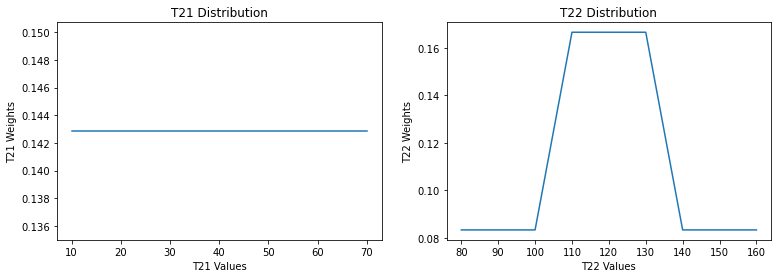

In [113]:
fig, ax = plt.subplots(1, 2, figsize = (12.8, 4))
ax[0].plot(T21_values, T21_distribution)
ax[0].set_title('T21 Distribution')
ax[0].set_xlabel('T21 Values')
ax[0].set_ylabel('T21 Weights')
ax[1].plot(T22_values, T22_distribution)
ax[1].set_title('T22 Distribution')
ax[1].set_xlabel('T22 Values')
ax[1].set_ylabel('T22 Weights')

plt.show()

#### Create a weighted average of MSE ratios

In [114]:
T21_weighted = 0
T22_weighted = 0

for i in range(n_T21):
    for j in range(n_T22):
        T21_weighted += T21_heatmap[i][j]*(T21_distribution[i]*T22_distribution[j])
        T22_weighted += T22_heatmap[i][j]*(T21_distribution[i]*T22_distribution[j])

#### Create a weighted average of lambdas

#### Determine success of regularization

In [115]:
print('T21 MSE ratio weighted average =', round(T21_weighted,2))
if (T21_weighted < 1):
    print('T21 MSE ratio is less than 1, regularization succeeded for T21')
else:
    print('T21 MSE ratio is greater than 1, regularization failed for T21')
print('\n')

print('T22 MSE ratio weighted average =', round(T22_weighted,2))
if (T22_weighted < 1):
    print('T22 MSE ratio is less than 1, regularization succeeded for T22')
else:
    print('T22 MSE ratio is greater than 1, regularization failed for T22')

T21 MSE ratio weighted average = 0.41
T21 MSE ratio is less than 1, regularization succeeded for T21


T22 MSE ratio weighted average = 0.99
T22 MSE ratio is less than 1, regularization succeeded for T22


# Given the distributions, find the best lambda

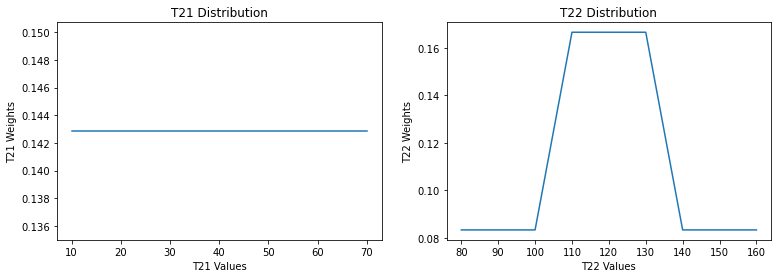

In [116]:
#Define T21 as evenly distributed between 10 and 70, normalized
T21_distribution = np.array([1]*n_T21)
T21_distribution = T21_distribution/T21_distribution.sum()
#Define T22 as empirically peaked at 120, normalized
T22_distribution = np.array([1,1,1,2,2,2,1,1,1])
T22_distribution = T22_distribution/T22_distribution.sum()

fig, ax = plt.subplots(1, 2, figsize = (12.8, 4))
ax[0].plot(T21_values, T21_distribution)
ax[0].set_title('T21 Distribution')
ax[0].set_xlabel('T21 Values')
ax[0].set_ylabel('T21 Weights')
ax[1].plot(T22_values, T22_distribution)
ax[1].set_title('T22 Distribution')
ax[1].set_xlabel('T22 Values')
ax[1].set_ylabel('T22 Weights')

plt.show()

In [117]:
center_lambda = -3
candidate_lambdas = np.logspace(center_lambda-2, center_lambda+2, 50)

n_T21 = 7
n_T22 = 9
T21_values = np.linspace(10, 70, n_T21)
T22_values = np.linspace(80, 160, n_T22)

T21_lambda_averages = []
T22_lambda_averages = []

for lam in candidate_lambdas:
    #Calculate the weighted average of MSE across the T2 distributions
    T21_MSE_ratios = np.zeros((n_T21, n_T22))
    T22_MSE_ratios = np.zeros((n_T21, n_T22))
    
    for i in range(n_T21):
        for j in range(n_T22):
            #Fill a matrix with the T2 ratios at that value of lambda
            MSE_T21, MSE_T22, MSE_T21_reg, MSE_T22_reg = find_MSE(T21_values[i], T22_values[j], lam)
        
            T21_ratio = MSE_T21_reg/MSE_T21
            T22_ratio = MSE_T22_reg/MSE_T22
        
            T21_MSE_ratios[i][j] = T21_ratio
            T22_MSE_ratios[i][j] = T22_ratio
    
    T21_weighted = 0
    T22_weighted = 0
    for i in range(n_T21):
        for j in range(n_T22):
            T21_weighted += T21_MSE_ratios[i][j]*(T21_distribution[i]*T22_distribution[j])
            T22_weighted += T22_MSE_ratios[i][j]*(T21_distribution[i]*T22_distribution[j])
    
    T21_lambda_averages.append(T21_weighted)
    T22_lambda_averages.append(T22_weighted)

<ipython-input-93-2ceda55a0bd1>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


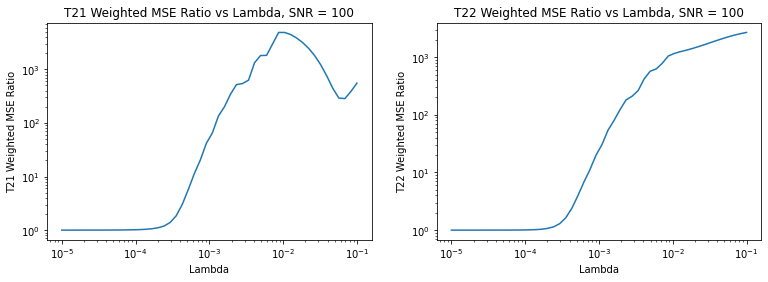

In [120]:
fig, ax = plt.subplots(1,2, figsize = (12.8,4))

ax[0].loglog(candidate_lambdas, T21_lambda_averages)
ax[0].set_title('T21 Weighted MSE Ratio vs Lambda, SNR = %s' % SNR)
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('T21 Weighted MSE Ratio')

ax[1].loglog(candidate_lambdas, T22_lambda_averages)
ax[1].set_title('T22 Weighted MSE Ratio vs Lambda, SNR = %s' % SNR)
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('T22 Weighted MSE Ratio')

plt.show()

# Generate weighted MSE graphs from prior distributions

In [45]:
n_lambdas = 100 #Number of lambdas to loop through
lambdas = np.logspace(-7, 3, num = n_lambdas) #Set range of lambda values
n_T21 = 3
n_T22 = 3
T21_values = np.linspace(65, 75, n_T21)
T22_values = np.linspace(80, 90, n_T22)
n_noise_realizations = 100
SNR = 100
noise_sd = 1/SNR

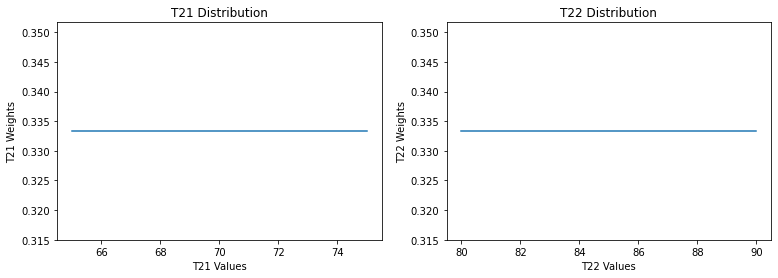

In [46]:
T21_distribution = np.array([1]*n_T21)
T21_distribution = T21_distribution/T21_distribution.sum()
#Define T22 as empirically peaked at 120, normalized
T22_distribution = np.array([1]*n_T22)
T22_distribution = T22_distribution/T22_distribution.sum()

fig, ax = plt.subplots(1, 2, figsize = (12.8, 4))
ax[0].plot(T21_values, T21_distribution)
ax[0].set_title('T21 Distribution')
ax[0].set_xlabel('T21 Values')
ax[0].set_ylabel('T21 Weights')
ax[1].plot(T22_values, T22_distribution)
ax[1].set_title('T22 Distribution')
ax[1].set_xlabel('T22 Values')
ax[1].set_ylabel('T22 Weights')

plt.show()

In [47]:
start_time = time.time()
bias = np.zeros((n_T21, n_T22, n_lambdas, 2))
variance = np.zeros((n_T21, n_T22, n_lambdas, 2))
MSE = np.zeros((n_T21, n_T22, n_lambdas, 2))
for nt1 in range(n_T21):
    for nt2 in range(n_T22):
        #Allocate 2 n x nl matrices for estimated T21 and T22 values
        T21est = np.zeros((n_noise_realizations, n_lambdas))
        T22est = np.zeros((n_noise_realizations, n_lambdas))
        
        for n in range(n_noise_realizations):
            #Generate n different noise realizations
            np.random.seed(n)
            noiseless_curve = G(tdata, T21_values[nt1], T22_values[nt2])
            d = noiseless_curve + noise(noise_sd)
            d_tilde = np.append(d,[0,0])
            
            #For each noise realization, estimate parameters for each value of lambda
            for l in range(n_lambdas):
                lam = lambdas[l]
                def G_tilde(t, time1, time2): #Augmented for regularization
                    return np.append(G(t, time1, time2), [lam*time1, lam*time2])
                
                popt, pcov = curve_fit(G_tilde, tdata, d_tilde, p0 = [40, 100])
                
                if popt[1]>popt[0]:
                    T21est[n,l] = popt[0]
                    T22est[n,l] = popt[1]
                else:
                    T21est[n,l] = popt[1]
                    T22est[n,l] = popt[0]
        
        #For each combination of T21 and T22, calculate bias, variance, and MSE as a function of lambda
        for l in range(n_lambdas):
            T21_column = T21est[:,l]
            T22_column = T22est[:,l]
            
            T21_bias = (1/n_noise_realizations)*((T21_column - [T21_values[nt1]]*n_noise_realizations).sum())
            T22_bias = (1/n_noise_realizations)*((T22_column - [T22_values[nt2]]*n_noise_realizations).sum())
            
            T21_variance = statistics.pvariance(T21_column)
            T22_variance = statistics.pvariance(T22_column)
            
            T21_MSE = T21_variance + T21_bias**2
            T22_MSE = T22_variance + T22_bias**2
            
            bias[nt1, nt2, l, 0] = T21_bias
            bias[nt1, nt2, l, 1] = T22_bias
            variance[nt1, nt2, l, 0] = T21_variance
            variance[nt1, nt2, l, 1] = T22_variance
            MSE[nt1, nt2, l, 0] = T21_MSE
            MSE[nt1, nt2, l, 1] = T22_MSE

#Calculate weighted averages of bias, variance, and MSE as a function of lambda
bias_weighted = np.zeros((n_lambdas, 2))
variance_weighted = np.zeros((n_lambdas, 2))
MSE_weighted = np.zeros((n_lambdas, 2))

for l in range(n_lambdas):
    temp_bias_array = np.zeros((n_T21, n_T22, 2))
    temp_variance_array = np.zeros((n_T21, n_T22, 2))
    temp_MSE_array = np.zeros((n_T21, n_T22, 2))
    for nt1 in range(n_T21):
        for nt2 in range(n_T22):
            weight = T21_distribution[nt1]*T22_distribution[nt2]
            temp_bias_array[nt1, nt2, 0] = weight*bias[nt1,nt2,l,0]
            temp_bias_array[nt1, nt2, 1] = weight*bias[nt1,nt2,l,1]
            temp_variance_array[nt1, nt2, 0] = weight*variance[nt1, nt2,l,0]
            temp_variance_array[nt1, nt2, 1] = weight*variance[nt1, nt2,l,1]
            temp_MSE_array[nt1, nt2, 0] = weight*MSE[nt1, nt2,l,0]
            temp_MSE_array[nt1, nt2, 1] = weight*MSE[nt1, nt2,l,1]
    
    bias_weighted[l,0] = temp_bias_array[:,:,0].sum()
    bias_weighted[l,1] = temp_bias_array[:,:,1].sum()
    variance_weighted[l,0] = temp_variance_array[:,:,0].sum()
    variance_weighted[l,1] = temp_variance_array[:,:,1].sum()
    MSE_weighted[l,0] = temp_MSE_array[:,:,0].sum()
    MSE_weighted[l,1] = temp_MSE_array[:,:,1].sum()
print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-2-33188db432e5>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


--- 60.06224727630615 seconds ---


#### Get weighted CRLB, Unreg MSE, and GCV MSE

In [48]:
start_time = time.time()
T21_weighted_CRLB = 0
T22_weighted_CRLB = 0

T21_weighted_uMSE = 0
T22_weighted_uMSE = 0

weighted_GCV_lam = 0

T21_weighted_GCV_bias = 0
T22_weighted_GCV_bias = 0

T21_weighted_GCV_variance = 0
T22_weighted_GCV_variance = 0

T21_weighted_GCV_MSE = 0
T22_weighted_GCV_MSE = 0

for nt1 in range(n_T21):
    for nt2 in range(n_T22):
        tau1 = T21_values[nt1]
        tau2 = T22_values[nt2]
        
        weight = T21_distribution[nt1]*T22_distribution[nt2]
        covariance = cov(tau1, tau2)
        T21_weighted_CRLB += covariance[0,0]
        T22_weighted_CRLB += covariance[1,1]
        
        #GCV Vector: avgGCV, varGCV, T21_bias, T21_variance, T21_MSE, T22_bias, T22_variance, T22_MSE
        GCV_values = get_avg_GCV(lambdas, tau1, tau2, n_noise_realizations, verbose=True)
        
        weighted_GCV_lam += weight*GCV_values[0]
        
        T21_weighted_GCV_bias += weight*GCV_values[2]
        T22_weighted_GCV_bias += weight*GCV_values[5]
        
        T21_weighted_GCV_variance += weight*GCV_values[3]
        T22_weighted_GCV_variance += weight*GCV_values[6]
        
        T21_weighted_GCV_MSE += weight*GCV_values[4]
        T22_weighted_GCV_MSE += weight*GCV_values[7]
        
        T21_MSE, T22_MSE, MSE_T21_reg, MSE_T22_reg = find_MSE(tau1, tau2, 0)
        T21_weighted_uMSE += weight*T21_MSE
        T22_weighted_uMSE += weight*T22_MSE
print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-2-33188db432e5>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


--- 77.50219440460205 seconds ---


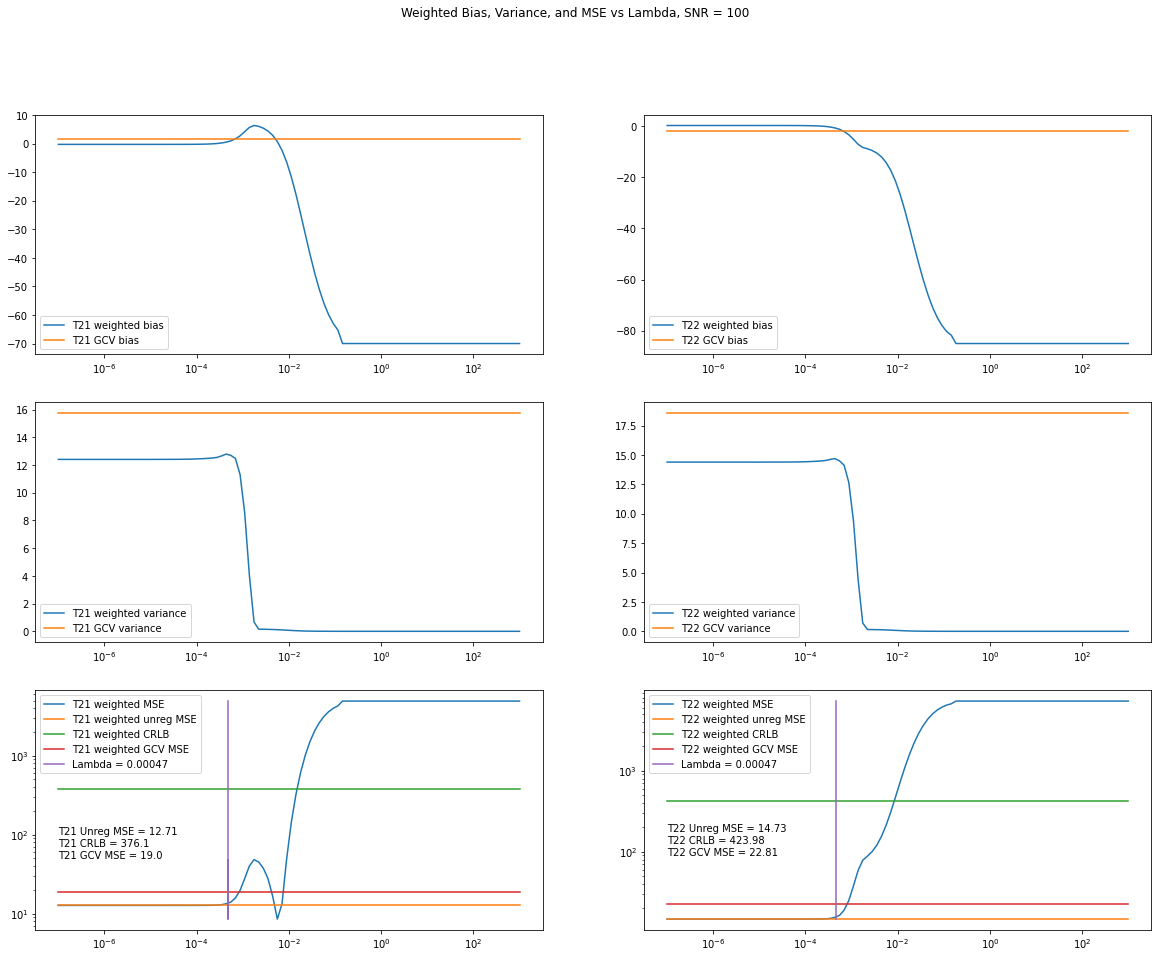

In [50]:
figure, axis = plt.subplots(3,2, figsize = (20, 15))

figure.suptitle('Weighted Bias, Variance, and MSE vs Lambda, SNR = %s' % SNR)
axis[0,0].semilogx(lambdas, bias_weighted[:,0], label='T21 weighted bias')
axis[0,0].semilogx(lambdas, [T21_weighted_GCV_bias]*n_lambdas, label='T21 GCV bias')
axis[0,1].semilogx(lambdas, bias_weighted[:,1], label='T22 weighted bias')
axis[0,1].semilogx(lambdas, [T22_weighted_GCV_bias]*n_lambdas, label='T22 GCV bias')

axis[1,0].semilogx(lambdas, variance_weighted[:,0], label='T21 weighted variance')
axis[1,0].semilogx(lambdas, [T21_weighted_GCV_variance]*n_lambdas, label='T21 GCV variance')
axis[1,1].semilogx(lambdas, variance_weighted[:,1], label='T22 weighted variance')
axis[1,1].semilogx(lambdas, [T22_weighted_GCV_variance]*n_lambdas, label='T22 GCV variance')

axis[2,0].loglog(lambdas, MSE_weighted[:,0], label='T21 weighted MSE')
axis[2,0].loglog(lambdas, [T21_weighted_uMSE]*n_lambdas, label='T21 weighted unreg MSE')
axis[2,0].loglog(lambdas, [T21_weighted_CRLB]*n_lambdas, label='T21 weighted CRLB')
axis[2,0].loglog(lambdas, [T21_weighted_GCV_MSE]*n_lambdas, label='T21 weighted GCV MSE')
axis[2,0].loglog([weighted_GCV_lam]*n_lambdas, MSE_weighted[:,0], label='Lambda = %s'%round(weighted_GCV_lam, 5))
axis[2,0].text(10**(-7),10**2, 'T21 Unreg MSE = %s' % round(T21_weighted_uMSE,2))
axis[2,0].text(10**(-7),10**1.85, 'T21 CRLB = %s' % round(T21_weighted_CRLB,2))
axis[2,0].text(10**(-7),10**1.7, 'T21 GCV MSE = %s' % round(T21_weighted_GCV_MSE,2))

axis[2,1].loglog(lambdas, MSE_weighted[:,1], label='T22 weighted MSE')
axis[2,1].loglog(lambdas, [T22_weighted_uMSE]*n_lambdas, label='T22 weighted unreg MSE')
axis[2,1].loglog(lambdas, [T22_weighted_CRLB]*n_lambdas, label='T22 weighted CRLB')
axis[2,1].loglog(lambdas, [T22_weighted_GCV_MSE]*n_lambdas, label='T22 weighted GCV MSE')
axis[2,1].loglog([weighted_GCV_lam]*n_lambdas, MSE_weighted[:,1], label='Lambda = %s'%round(weighted_GCV_lam, 5))
axis[2,1].text(10**(-7),10**2.25, 'T22 Unreg MSE = %s' % round(T22_weighted_uMSE,2))
axis[2,1].text(10**(-7),10**2.1, 'T22 CRLB = %s' % round(T22_weighted_CRLB,2))
axis[2,1].text(10**(-7),10**1.95, 'T22 GCV MSE = %s' % round(T22_weighted_GCV_MSE,2))

for i in range(3):
    for j in range(2):
        axis[i,j].legend()

plt.show()

# Iterative methods of solving for lambda

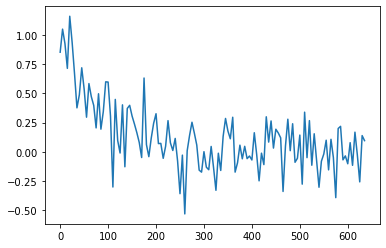

In [40]:
noiseless_curve = G(tdata, 90, 100)
data = noiseless_curve + noise(noise_sd)
data_tilde = np.append(data,[0,0])
plt.plot(tdata, data)

#### Optimize around parameters with one lambda at a time

In [41]:
start_time = time.time()
n_loops = 10

estimates_list = np.zeros((n_loops+1, 2))
optlam_list = np.zeros((n_loops+1, 2))

optlam=0
#Estimate T21 using T21 lambdas, T22 using T22 lambdas
for p in range(2):
    #p=0:T21, p=1:T22
    for i in range(n_loops):
        #Set the lambda for regularization, starts at 0
        optlam = optlam_list[i,p]
        #Estimate the parameters using this lambda
        estimates = estimate_parameters(data, optlam)
        #Keep only the estimate for the parameter which we are optimizing around
        estimates_list[i,p] = estimates[p]
        #Generate noise realizations and find the optimal lambda for each parameter
        optlam_list[i+1,p] = find_optimal_lambdas(estimates[0], estimates[1])[p]
#Estimate parameters one last time with the final lambda
estimates_list[n_loops,0] = estimate_parameters(data, optlam_list[n_loops,0])[0]
estimates_list[n_loops,1] = estimate_parameters(data, optlam_list[n_loops,1])[1]
print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-39-1813c0295f2a>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)
C:\Users\neffrya\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


--- 608.1153354644775 seconds ---


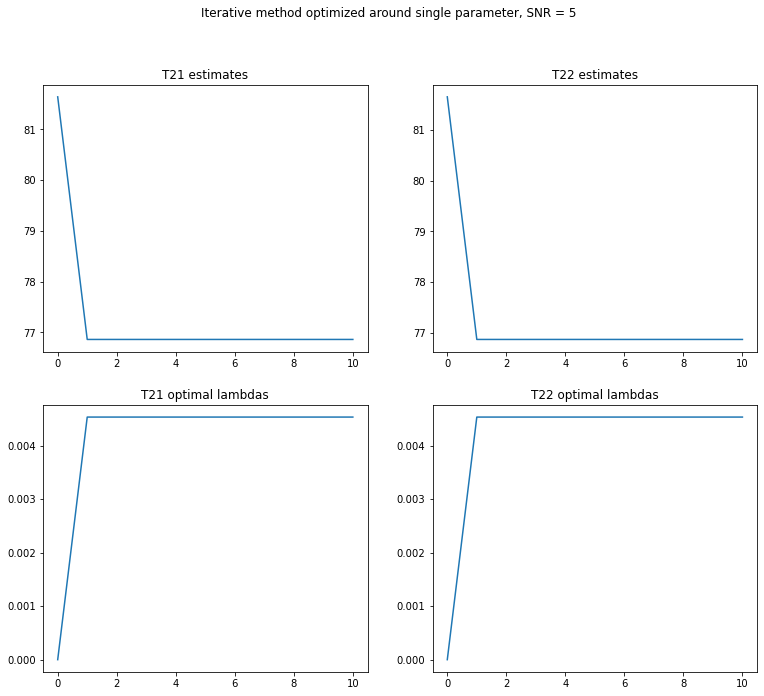

In [42]:
figure, axis = plt.subplots(2,2,figsize = (12.8, 10.8))

figure.suptitle('Iterative method optimized around single parameter, SNR = %s' % SNR)

axis[0,0].plot(range(n_loops+1), estimates_list[:,0])
axis[0,0].set_title('T21 estimates')
axis[0,1].plot(range(n_loops+1), estimates_list[:,1])
axis[0,1].set_title('T22 estimates')
axis[1,0].plot(range(n_loops+1), optlam_list[:,0])
axis[1,0].set_title('T21 optimal lambdas')
axis[1,1].plot(range(n_loops+1), optlam_list[:,1])
axis[1,1].set_title('T22 optimal lambdas')

plt.show()

#### Optimize using 2 different lambdas at the same time

In [80]:
start_time = time.time()
n_loops = 10

estimates_list = np.zeros((n_loops+1, 2))
optlam_list = np.zeros((n_loops+1, 2))

lambdas = np.logspace(-7, 3, 100)

for i in range(n_loops):
    #Define a G~ using a different lambda for each parameter
    T21_optlam = optlam_list[i,0]
    T22_optlam = optlam_list[i,1]
    
    def G2_tilde(t, tau_1, tau_2):
        return np.append(G(t, tau_1, tau_2), [T21_optlam*tau_1, T22_optlam*tau_2])
        
    #Estimate the parameters from the data using the 2 optlams 
    (T21_estimate_reg, T22_estimate_reg), cov_reg = curve_fit(G2_tilde, tdata, data_tilde, p0=[40,100])
        
    #Require that T22>T21
    if T22_estimate_reg > T21_estimate_reg:
        T21est = T21_estimate_reg
        T22est = T22_estimate_reg
    else:
        T21est = T22_estimate_reg
        T22est = T21_estimate_reg
    
    estimates_list[i,0] = T21est
    estimates_list[i,1] = T22est
    noiseless_curve = G(tdata, T21est, T22est)
    
    #First fix T22_optlam and find T21_optlam
    #Find MSE, variance, and bias as a function of lambda
    tau_1_MSE = []

    for reg_param in lambdas:
        
        estimated_tau_1 = []
        
        def G_tilde(t, tau_1, tau_2): #Augmented for regularization
            return np.append(G(t, tau_1, tau_2), [reg_param*tau_1, T22_optlam*tau_2])
    
        #Loop through noise realizations to populate estimated tau arrays
        for j in range(n_noise_realizations):
            np.random.seed(j)

            d = noiseless_curve + noise(noise_sd)
            d_tilde = np.append(d, [0,0])
    
            popt, pcov = curve_fit(G_tilde, tdata, d_tilde, p0 = [40, 100])

            if popt[1] > popt[0]:
                estimated_tau_1.append(popt[0])
            else:
                estimated_tau_1.append(popt[1])
    
        estimated_tau_1 = np.array(estimated_tau_1)
        MSE_lambda_tau_1 = (1/n_noise_realizations)*(((estimated_tau_1 - [T21est for tau in estimated_tau_1])**2).sum())
        tau_1_MSE.append(MSE_lambda_tau_1)
        
    #Set optimal T21 lambda
    tau_1_MSE = np.array(tau_1_MSE)
    optlam_list[i+1,0] = lambdas[np.argmin(tau_1_MSE)]

    #Next fix T21_optlam and find T22_optlam
    #Find MSE, variance, and bias as a function of lambda
    tau_2_MSE = []

    for reg_param in lambdas:
        
        estimated_tau_2 = []
        
        def G_tilde(t, tau_1, tau_2): #Augmented for regularization
            return np.append(G(t, tau_1, tau_2), [T21_optlam*tau_1, reg_param*tau_2])
    
        #Loop through noise realizations to populate estimated tau arrays
        for j in range(n_noise_realizations):
            np.random.seed(j)

            d = noiseless_curve + noise(noise_sd)
            d_tilde = np.append(d, [0,0])
    
            popt, pcov = curve_fit(G_tilde, tdata, d_tilde, p0 = [40, 100])

            if popt[1] > popt[0]:
                estimated_tau_2.append(popt[1])
            else:
                estimated_tau_2.append(popt[0])
    
        estimated_tau_2 = np.array(estimated_tau_2)
        MSE_lambda_tau_2 = (1/n_noise_realizations)*(((estimated_tau_2 - [T22est for tau in estimated_tau_2])**2).sum())
        tau_2_MSE.append(MSE_lambda_tau_2)
        
    #Set optimal T21 lambda
    tau_2_MSE = np.array(tau_2_MSE)
    optlam_list[i+1,1] = lambdas[np.argmin(tau_2_MSE)]

#Estimate the parameters one last time with the final lambdas
T21_optlam = optlam_list[n_loops,0]
T22_optlam = optlam_list[n_loops,1]

def G2_tilde(t, tau_1, tau_2):
    return np.append(G(t, tau_1, tau_2), [T21_optlam*tau_1, T22_optlam*tau_2])
        
#Estimate the parameters from the data using the 2 optlams 
popt, pcov = curve_fit(G2_tilde, tdata, data_tilde, p0 = [40, 100])
        
#Require that T22>T21
if popt[1] > popt[0]:
    estimates_list[n_loops,0] = popt[0]
    estimates_list[n_loops,1] = popt[1]
else:
    estimates_list[n_loops,0] = popt[1]
    estimates_list[n_loops,1] = popt[0]

print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-79-e2ad47da8881>:14: RuntimeWarning: overflow encountered in exp
  function = c1*np.exp(-t/tau_1) + c2*np.exp(-t/tau_2)


KeyboardInterrupt: 

In [255]:
optlam_list

array([[0.00000000e+00, 0.00000000e+00],
       [1.59228279e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04],
       [2.00923300e-07, 2.15443469e-04]])

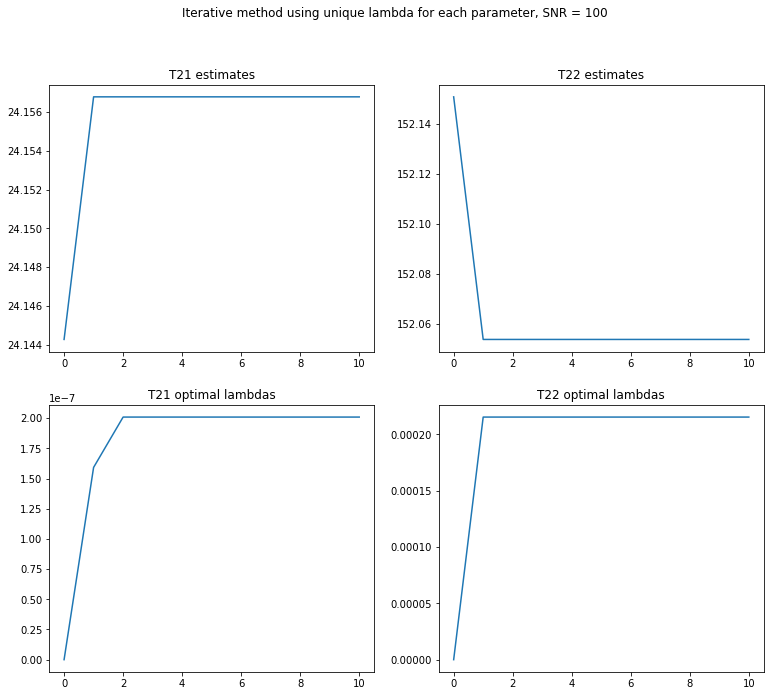

In [191]:
figure, axis = plt.subplots(2,2,figsize = (12.8, 10.8))

figure.suptitle('Iterative method using unique lambda for each parameter, SNR = %s' % SNR)

axis[0,0].plot(range(n_loops+1), estimates_list[:,0])
axis[0,0].set_title('T21 estimates')
axis[0,1].plot(range(n_loops+1), estimates_list[:,1])
axis[0,1].set_title('T22 estimates')
axis[1,0].plot(range(n_loops+1), optlam_list[:,0])
axis[1,0].set_title('T21 optimal lambdas')
axis[1,1].plot(range(n_loops+1), optlam_list[:,1])
axis[1,1].set_title('T22 optimal lambdas')

plt.show()